In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import time
time_start = time.time()

In [ ]:
train_ds = CIFAR100(root='data/', download=True, train=True, transform=ToTensor())
test_ds = CIFAR100(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
n_classes = len(train_ds.classes)
n_classes

100

In [ ]:
len(train_ds)

50000

In [ ]:
train_size = int(len(train_ds) * 0.85)
val_size = len(train_ds) - train_size

train_size, val_size

(42500, 7500)

In [ ]:
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

len(train_ds), len(val_ds)

(42500, 7500)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=4, num_workers=2, pin_memory=True)

torch.Size([100, 3, 32, 32])


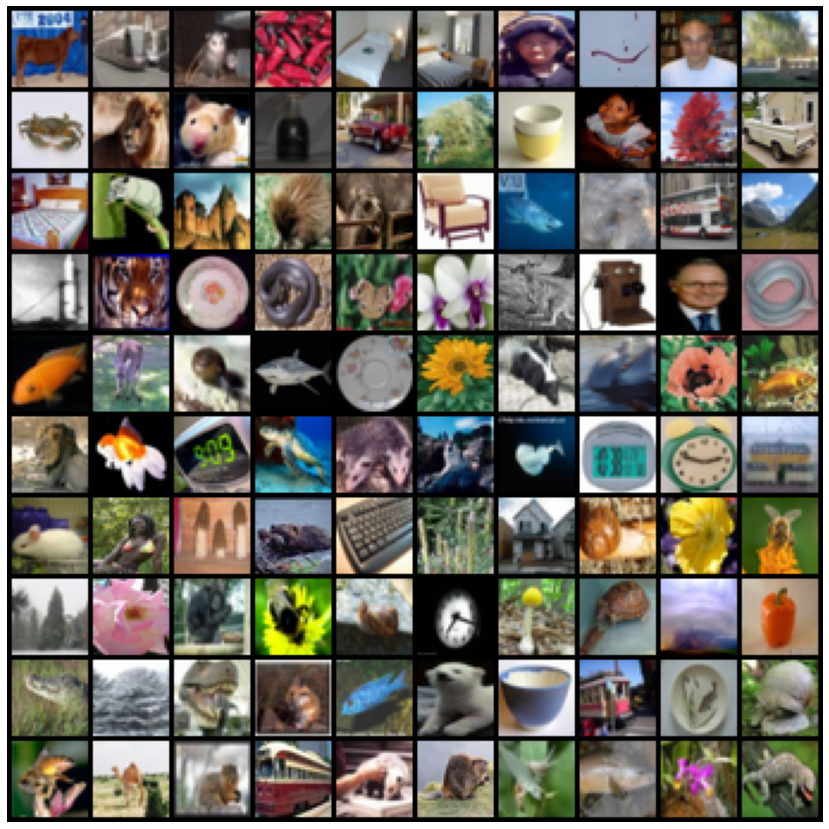

In [ ]:
for images, _ in train_loader:
  print(images.shape)
  plt.figure(figsize=(15,15))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute((1,2,0)))
  break

#base

In [ ]:
def accuracy(out, targets):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == targets).item() / len(preds))

In [ ]:
class CIFAR100ModelBase(nn.Module):
  def training_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    return loss

  def validation_step(self, batch):
    xb, targets = batch
    out = self(xb)
    val_loss = F.cross_entropy(out, targets)
    val_acc = accuracy(out, targets)
    return {'val_loss': val_loss, 'val_acc': val_acc}

  def validation_epoch_end(self, res):
    losses = [x['val_loss'] for x in res]
    epoch_loss = torch.stack(losses).mean()
    accs = [x['val_acc'] for x in res]
    epoch_acc = torch.stack(accs).mean()
    return {'epoch_loss': epoch_loss.detach().item(), 'epoch_acc': epoch_acc.item()}

  def epoch_end(self, epoch, res):
    print(f'Epoch [{epoch}], Epoch loss: [{round(res["epoch_loss"], 4)}], Epoch accuracy: [{round(res["epoch_acc"], 4)}]')

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
def evaluate(model, dl):
  res = [model.validation_step(b) for b in dl]
  return model.validation_epoch_end(res)

In [ ]:
def fit(n_epochs, model, train_loader, val_loader, lr, opt_f=torch.optim.SGD):
  history = []
  opt = opt_f(model.parameters(), lr)

  for epoch in range(n_epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()

    res = evaluate(model, val_loader)
    history.append(res)
    model.epoch_end(epoch, res)
  return history

In [ ]:
def plot_losses(history):
  losses = [x['epoch_loss'] for x in history]
  print(f'Minimal loss is {min(losses)} on the {losses.index(min(losses))}')
  plt.figure(figsize=(20, 8))
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy score')
  plt.title('Losses X Epoch')

In [ ]:
def plot_accuracies(history):
  accs = [x['epoch_acc'] for x in history]
  print(f'Max accuracy is {max(accs)*100} % on the {accs.index(max(accs))}')
  plt.figure(figsize=(20, 8))
  plt.plot(accs)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy score')
  plt.title('Losses X Epoch')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

#model1

In [ ]:
for img, _ in train_loader:
  print(img.shape)
  break

torch.Size([100, 3, 32, 32])


In [ ]:
in_size = 3 * 32 * 32
in_size

3072

In [ ]:
class CIFAR100Model1(CIFAR100ModelBase):
  def __init__(self, in_size=3072, n_classes=100):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 2048)
    self.linear2 = nn.Linear(2048, 1024)
    self.linear3 = nn.Linear(1024, 512)
    self.linear4 = nn.Linear(512, 256)
    self.linear5 = nn.Linear(256, 128)
    self.linear6 = nn.Linear(128, n_classes)
  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    return out

In [ ]:
model1 = CIFAR100Model1()

In [ ]:
model1 = to_device(model1, device)

In [ ]:
device

device(type='cuda')

In [ ]:
history1 = [evaluate(model1, val_loader)]
history1

[{'epoch_acc': 0.009600000455975533, 'epoch_loss': 4.606575965881348}]

In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.5)

Epoch [0], Epoch loss: [4.4764], Epoch accuracy: [0.0257]
Epoch [1], Epoch loss: [4.1361], Epoch accuracy: [0.0489]
Epoch [2], Epoch loss: [4.0709], Epoch accuracy: [0.0563]
Epoch [3], Epoch loss: [4.0142], Epoch accuracy: [0.0703]
Epoch [4], Epoch loss: [4.0469], Epoch accuracy: [0.0653]
Epoch [5], Epoch loss: [3.9194], Epoch accuracy: [0.0895]
Epoch [6], Epoch loss: [3.805], Epoch accuracy: [0.1093]
Epoch [7], Epoch loss: [3.7306], Epoch accuracy: [0.1176]
Epoch [8], Epoch loss: [3.7094], Epoch accuracy: [0.1299]
Epoch [9], Epoch loss: [3.6407], Epoch accuracy: [0.1449]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.5)

Epoch [0], Epoch loss: [3.5969], Epoch accuracy: [0.1452]
Epoch [1], Epoch loss: [3.5281], Epoch accuracy: [0.1559]
Epoch [2], Epoch loss: [3.5329], Epoch accuracy: [0.1675]
Epoch [3], Epoch loss: [3.5219], Epoch accuracy: [0.1689]
Epoch [4], Epoch loss: [3.5003], Epoch accuracy: [0.1695]
Epoch [5], Epoch loss: [3.4975], Epoch accuracy: [0.1737]
Epoch [6], Epoch loss: [3.5278], Epoch accuracy: [0.174]
Epoch [7], Epoch loss: [3.5421], Epoch accuracy: [0.1753]
Epoch [8], Epoch loss: [3.4679], Epoch accuracy: [0.1855]
Epoch [9], Epoch loss: [3.5321], Epoch accuracy: [0.1753]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.4)

Epoch [0], Epoch loss: [3.4392], Epoch accuracy: [0.1977]
Epoch [1], Epoch loss: [3.4057], Epoch accuracy: [0.2059]
Epoch [2], Epoch loss: [3.4388], Epoch accuracy: [0.2003]
Epoch [3], Epoch loss: [3.5314], Epoch accuracy: [0.1935]
Epoch [4], Epoch loss: [3.5271], Epoch accuracy: [0.1968]
Epoch [5], Epoch loss: [3.5035], Epoch accuracy: [0.2039]
Epoch [6], Epoch loss: [3.4965], Epoch accuracy: [0.2073]
Epoch [7], Epoch loss: [3.5938], Epoch accuracy: [0.2027]
Epoch [8], Epoch loss: [3.5419], Epoch accuracy: [0.2036]
Epoch [9], Epoch loss: [3.6259], Epoch accuracy: [0.1987]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.3)

Epoch [0], Epoch loss: [3.6114], Epoch accuracy: [0.2063]
Epoch [1], Epoch loss: [3.7095], Epoch accuracy: [0.2068]
Epoch [2], Epoch loss: [3.7693], Epoch accuracy: [0.2123]
Epoch [3], Epoch loss: [3.8115], Epoch accuracy: [0.2065]
Epoch [4], Epoch loss: [3.897], Epoch accuracy: [0.2045]
Epoch [5], Epoch loss: [3.9504], Epoch accuracy: [0.1995]
Epoch [6], Epoch loss: [4.0188], Epoch accuracy: [0.2044]
Epoch [7], Epoch loss: [4.0676], Epoch accuracy: [0.2004]
Epoch [8], Epoch loss: [4.0386], Epoch accuracy: [0.1925]
Epoch [9], Epoch loss: [4.0966], Epoch accuracy: [0.1989]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.2)

Epoch [0], Epoch loss: [4.3706], Epoch accuracy: [0.2188]
Epoch [1], Epoch loss: [4.636], Epoch accuracy: [0.2209]
Epoch [2], Epoch loss: [4.9036], Epoch accuracy: [0.2025]
Epoch [3], Epoch loss: [4.9981], Epoch accuracy: [0.2033]
Epoch [4], Epoch loss: [5.0118], Epoch accuracy: [0.2097]
Epoch [5], Epoch loss: [5.2276], Epoch accuracy: [0.2132]
Epoch [6], Epoch loss: [5.2688], Epoch accuracy: [0.2004]
Epoch [7], Epoch loss: [5.3393], Epoch accuracy: [0.2033]
Epoch [8], Epoch loss: [5.4375], Epoch accuracy: [0.1999]
Epoch [9], Epoch loss: [5.5444], Epoch accuracy: [0.1953]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.1)

Epoch [0], Epoch loss: [6.3093], Epoch accuracy: [0.214]
Epoch [1], Epoch loss: [6.9561], Epoch accuracy: [0.2241]
Epoch [2], Epoch loss: [7.6073], Epoch accuracy: [0.2139]
Epoch [3], Epoch loss: [8.0247], Epoch accuracy: [0.216]
Epoch [4], Epoch loss: [8.6832], Epoch accuracy: [0.2164]
Epoch [5], Epoch loss: [9.1261], Epoch accuracy: [0.2204]
Epoch [6], Epoch loss: [9.4535], Epoch accuracy: [0.2171]
Epoch [7], Epoch loss: [10.0652], Epoch accuracy: [0.2179]
Epoch [8], Epoch loss: [10.5134], Epoch accuracy: [0.2195]
Epoch [9], Epoch loss: [10.8497], Epoch accuracy: [0.2205]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.01)

Epoch [0], Epoch loss: [10.9183], Epoch accuracy: [0.2203]
Epoch [1], Epoch loss: [10.9859], Epoch accuracy: [0.2213]
Epoch [2], Epoch loss: [11.0359], Epoch accuracy: [0.2212]
Epoch [3], Epoch loss: [11.0956], Epoch accuracy: [0.2217]
Epoch [4], Epoch loss: [11.1443], Epoch accuracy: [0.2213]
Epoch [5], Epoch loss: [11.1955], Epoch accuracy: [0.2223]
Epoch [6], Epoch loss: [11.2517], Epoch accuracy: [0.2217]
Epoch [7], Epoch loss: [11.2882], Epoch accuracy: [0.2224]
Epoch [8], Epoch loss: [11.3356], Epoch accuracy: [0.2224]
Epoch [9], Epoch loss: [11.3743], Epoch accuracy: [0.2223]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.05)

Epoch [0], Epoch loss: [11.553], Epoch accuracy: [0.2227]
Epoch [1], Epoch loss: [11.7263], Epoch accuracy: [0.2209]
Epoch [2], Epoch loss: [11.8676], Epoch accuracy: [0.2225]
Epoch [3], Epoch loss: [11.992], Epoch accuracy: [0.2231]
Epoch [4], Epoch loss: [12.1272], Epoch accuracy: [0.2248]
Epoch [5], Epoch loss: [12.261], Epoch accuracy: [0.2239]
Epoch [6], Epoch loss: [12.356], Epoch accuracy: [0.2243]
Epoch [7], Epoch loss: [12.4539], Epoch accuracy: [0.2245]
Epoch [8], Epoch loss: [12.5525], Epoch accuracy: [0.2245]
Epoch [9], Epoch loss: [12.6162], Epoch accuracy: [0.2237]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.025)

Epoch [0], Epoch loss: [12.6733], Epoch accuracy: [0.2247]
Epoch [1], Epoch loss: [12.7114], Epoch accuracy: [0.2247]
Epoch [2], Epoch loss: [12.7635], Epoch accuracy: [0.2248]
Epoch [3], Epoch loss: [12.7963], Epoch accuracy: [0.2253]
Epoch [4], Epoch loss: [12.84], Epoch accuracy: [0.2244]
Epoch [5], Epoch loss: [12.8748], Epoch accuracy: [0.2247]
Epoch [6], Epoch loss: [12.9138], Epoch accuracy: [0.2247]
Epoch [7], Epoch loss: [12.9495], Epoch accuracy: [0.2243]
Epoch [8], Epoch loss: [12.985], Epoch accuracy: [0.2245]
Epoch [9], Epoch loss: [13.0158], Epoch accuracy: [0.2249]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.01)

Epoch [0], Epoch loss: [13.0328], Epoch accuracy: [0.2244]
Epoch [1], Epoch loss: [13.0479], Epoch accuracy: [0.2237]
Epoch [2], Epoch loss: [13.0607], Epoch accuracy: [0.224]
Epoch [3], Epoch loss: [13.0737], Epoch accuracy: [0.2245]
Epoch [4], Epoch loss: [13.087], Epoch accuracy: [0.2237]
Epoch [5], Epoch loss: [13.1001], Epoch accuracy: [0.2244]
Epoch [6], Epoch loss: [13.1132], Epoch accuracy: [0.224]
Epoch [7], Epoch loss: [13.1263], Epoch accuracy: [0.224]
Epoch [8], Epoch loss: [13.1401], Epoch accuracy: [0.2244]
Epoch [9], Epoch loss: [13.1528], Epoch accuracy: [0.224]


Minimal loss is 3.405674934387207 on the 22


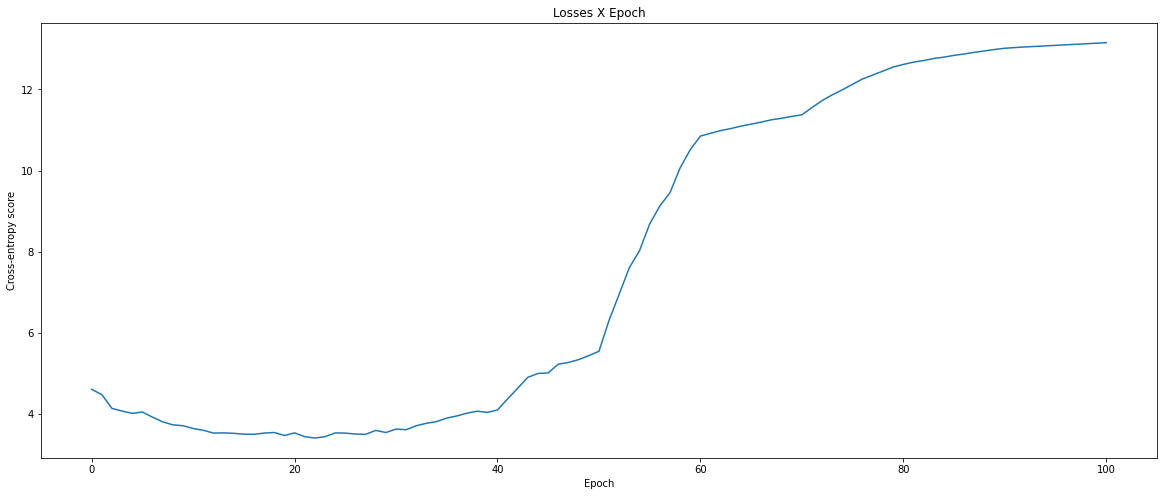

In [ ]:
plot_losses(history1)

Max accuracy is 22.53333330154419 % on the 84


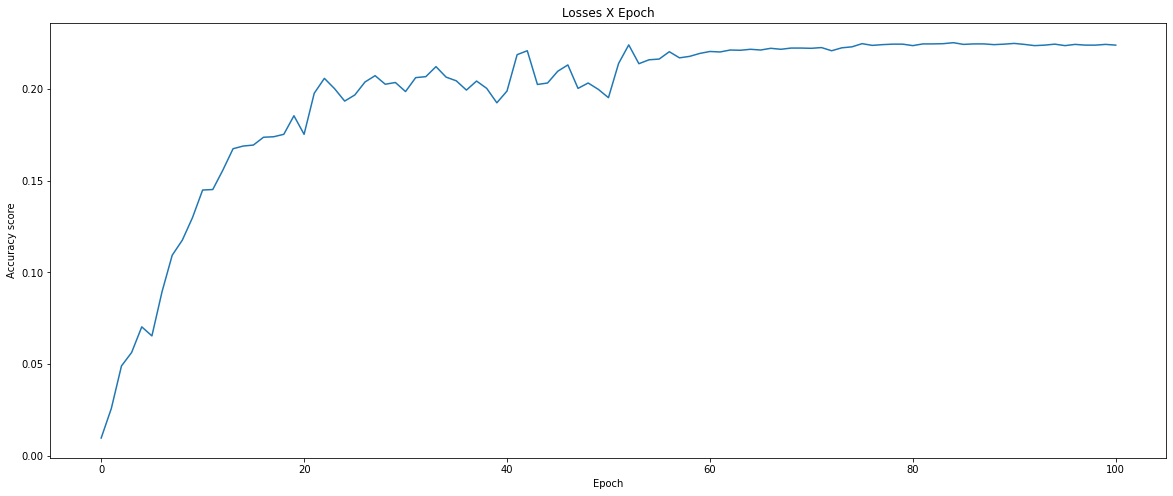

In [ ]:
plot_accuracies(history1)